In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from itertools import cycle
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
from scikitplot.estimators import plot_learning_curve

from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('df_bkg_red.csv').drop(columns = 'Unnamed: 0')
models = ['A', 'B', 'C', 'D']
for i in models:
    df = pd.concat([df, pd.read_csv('df_model%s_red.csv'%(i)).drop(columns = 'Unnamed: 0')], ignore_index=True) 

In [5]:
df_bin = df.copy()
df_bin.labels = df.labels.replace([2, 3, 4], 1)

In [6]:
labels_bin = df_bin.labels

In [7]:
features = df.iloc[:, :-2]
labels = df.labels

In [8]:
features

,mjjs,dyjjs,pt_asyms,lead_etas,sub_etas,lead_ungrs,sub_ungrs,lead_ntrk,sub_ntrk
0,1143.592529,0.039967,146.150787,0.525687,0.505117,38,48,-27.057099,-23.003627
1,1476.433716,1.387635,14.246826,-1.370057,0.113648,21,33,-47.325838,-42.513492
2,1540.057007,1.520813,94.611481,1.142746,-0.478356,46,31,-22.852907,-45.262825
3,1533.117432,1.955224,79.998779,-0.021801,1.994529,46,37,-22.796860,-39.182772
4,1164.201416,0.747826,97.815399,-0.216873,0.608687,40,45,-25.285624,-26.312875
...,...,...,...,...,...,...,...,...,...
2067579,2686.224854,1.818661,211.678955,0.903337,-0.919513,58,129,-16.311280,44.333506
2067580,2692.715088,0.938040,136.215576,0.324722,-0.615071,78,78,3.673315,-6.691277
2067581,2476.301514,0.264742,106.248535,0.488685,0.740875,200,96,126.251694,12.251655
2067582,2140.740234,1.310556,192.544434,-0.370099,0.945993,134,99,61.481212,17.241032


In [9]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
_, _, y_train_bin, y_test_bin = train_test_split(features, labels_bin, test_size=0.2, random_state=42)

In [10]:
x_test_control = x_test[(x_test.lead_ntrk < 0)]
x_test_control = x_test_control[(x_test_control.sub_ntrk < 0)]
x_train_control = x_train[(x_train.lead_ntrk < 0)]
x_train_control = x_train_control[(x_train_control.sub_ntrk < 0)]

y_test_control = y_test[x_test_control.index]
y_test_control_bin = y_test_bin[x_test_control.index]
y_train_control = y_train[x_train_control.index]
y_train_control_bin = y_train_bin[x_train_control.index]

In [11]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.iloc[:, :7])

x_train_control = scaler.fit_transform(x_train_control.iloc[:, :7])
x_test_control = scaler.fit_transform(x_test_control.iloc[:, :7])

In [18]:
tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=15,
                            min_samples_leaf=0.36931642349065275,
                           min_samples_split=0.7479086208293507)
bdt = AdaBoostClassifier(tree, 
                         learning_rate=0.9912684934237729, 
                         n_estimators=80)

In [11]:
bdt_bin = bdt

# Multi-class

In [30]:
bdt.fit(x_train_control, y_train_control)
pkl.dump(bdt, open('bdt_optimized_red_control.pkl', 'wb'))

In [31]:
y_preds = bdt.predict(x_test_control)
precision = precision_score(y_test_control, y_preds, average='weighted')
recall = recall_score(y_test_control, y_preds, average = 'weighted')
f1 = f1_score(y_test_control, y_preds, average = 'weighted')
accuracy = accuracy_score(y_test_control, y_preds)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

Precision: 0.702
Recall: 0.759
F1: 0.718
Accuracy: 0.759


<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

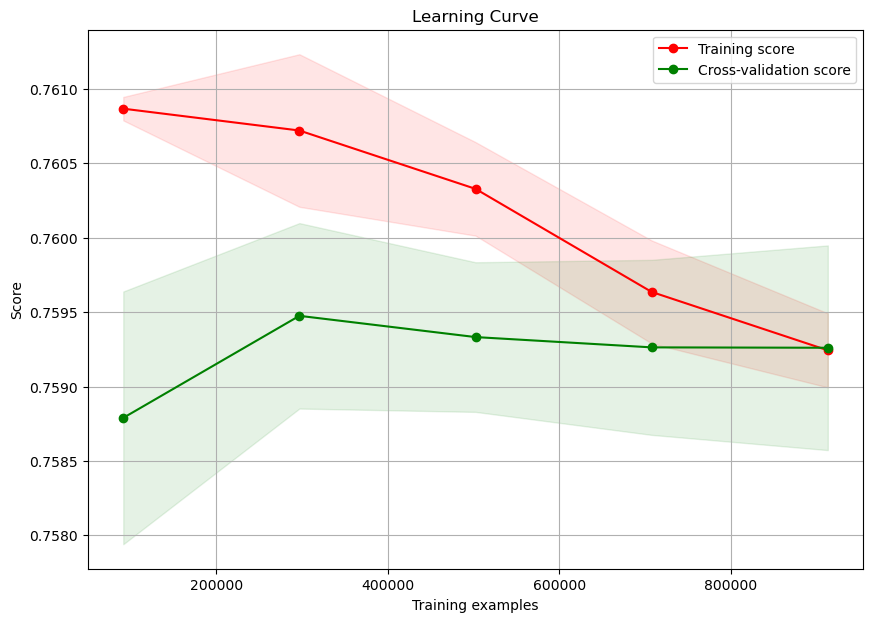

In [32]:
fig, ax = plt.subplots(figsize=(10, 7))
plot_learning_curve(bdt, X = x_train_control, y = y_train_control, ax=ax)

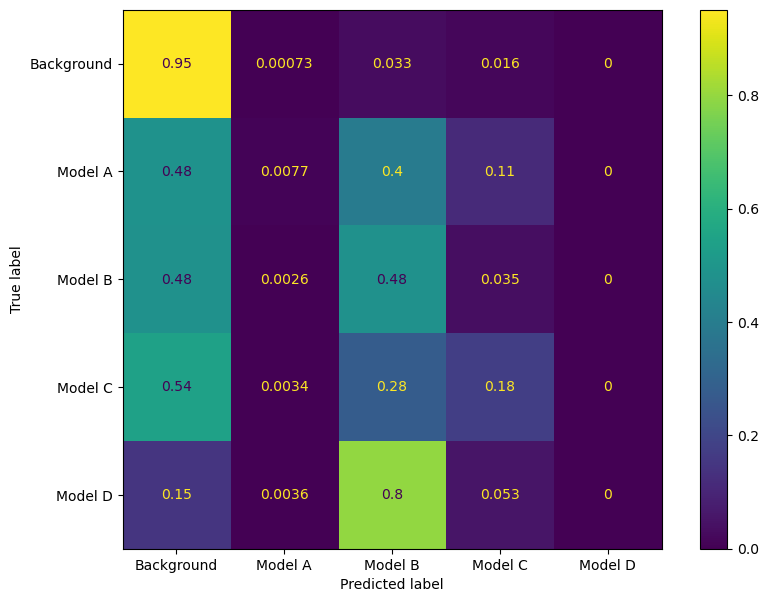

In [33]:
cm = confusion_matrix(y_test_control.values, y_preds, normalize='true')
tick_labs = ['Background', 'Model A', 'Model B', 'Model C', 'Model D']
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
fig, ax = plt.subplots(figsize = (10, 7))
cm_display.plot(ax=ax)
plt.show()

In [35]:
dat = dict()
for i in range(len(df.columns[:7])):
    dat[df.columns[i]] = str(round(bdt.feature_importances_[i], 3)*100)+'%'

In [36]:
dat

{'mjjs': '22.5%',
 'dyjjs': '8.799999999999999%',
 'pt_asyms': '7.5%',
 'lead_etas': '6.2%',
 'sub_etas': '6.2%',
 'lead_ungrs': '28.799999999999997%',
 'sub_ungrs': '20.0%'}

# Binary

In [38]:
bdt_bin.fit(x_train_control, y_train_control_bin)
pkl.dump(bdt, open('bdt_bin_optimized_red_control.pkl', 'wb'))

In [40]:
y_preds = bdt_bin.predict(x_test_control)
precision = precision_score(y_test_control_bin, y_preds)
recall = recall_score(y_test_control_bin, y_preds)
f1 = f1_score(y_test_control_bin, y_preds)
accuracy = accuracy_score(y_test_control_bin, y_preds)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

Precision: 0.738
Recall: 0.646
F1: 0.689
Accuracy: 0.832


<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

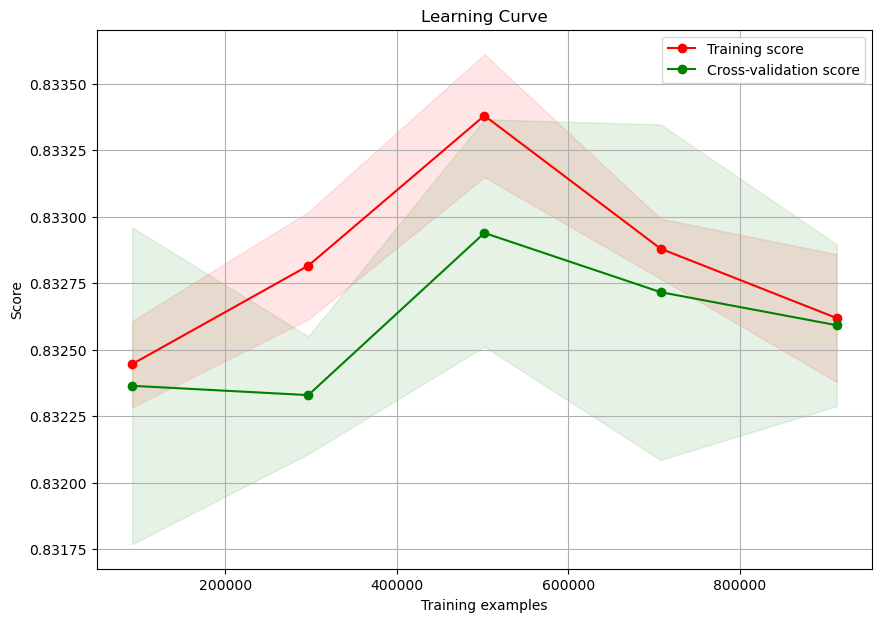

In [51]:
fig, ax = plt.subplots(figsize=(10, 7))
plot_learning_curve(bdt_bin, X = x_train_control, y = y_train_control_bin, ax=ax)

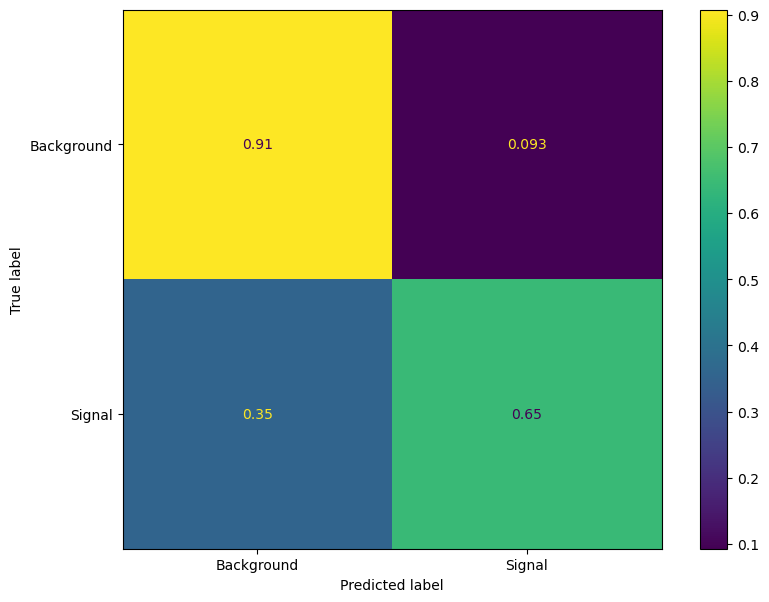

In [42]:
cm = confusion_matrix(y_test_control_bin.values, y_preds, normalize='true')
tick_labs = ['Background', 'Signal']
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
fig, ax = plt.subplots(figsize = (10, 7))
cm_display.plot(ax=ax)
plt.show()

In [54]:
dat = dict()
for i in range(len(df.columns[:7])):
    dat[df.columns[i]] = str(round(bdt_bin.feature_importances_[i], 3)*100)+'%'

In [55]:
dat

{'mjjs': '25.0%',
 'dyjjs': '8.799999999999999%',
 'pt_asyms': '11.200000000000001%',
 'lead_etas': '6.2%',
 'sub_etas': '7.5%',
 'lead_ungrs': '20.0%',
 'sub_ungrs': '21.2%'}

# Scores

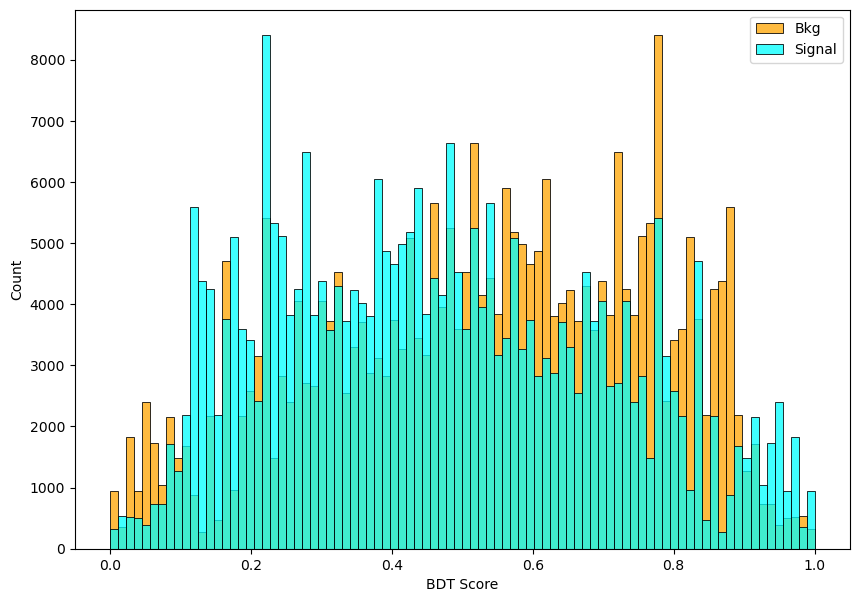

In [46]:
probs = bdt_bin.predict_proba(x_test_control)
preds = probs[:, 1]

scaled = MinMaxScaler().fit_transform(probs)
plt.figure(figsize=(10,7))
sns.histplot(x=scaled[:,0], color='orange', label = 'Bkg', bins=100)
sns.histplot(x=scaled[:,1], color='cyan', label = 'Signal', bins=100)
plt.xlabel('BDT Score')
plt.legend()
plt.show()

In [38]:
classes = [1, 2, 3, 4]
models = ['bkg','A', 'B', 'C', 'D']
for i in classes:
    new = classes.copy()
    new.remove(i)
    print(new)
    #y_test_new = y_test.replace(to_replace=new, value=0)
    #y_test_new = y_test_new.replace(i, 1)
    y_train_new = y_train_control.replace(to_replace = new, value = 0)
    y_train_new = y_train_new.replace(i, 1)
    bdt.fit(x_train_control, y_train_new)
    probs = bdt.predict_proba(x_test_control)
    preds = probs[:, 1]
    print(preds)
    scaled = MinMaxScaler().fit_transform(probs)
    plt.figure(figsize=(10,7))
    sns.histplot(x=scaled[:,0], color='orange', label = 'Model %s'%models[i], bins=100)
    sns.histplot(x=scaled[:,1], color='cyan', label = 'Bkg and Others', bins=100)
    plt.xlabel('BDT Score')
    plt.legend()
    plt.show()

[2, 3, 4]


AttributeError: 'AdaBoostClassifier' object has no attribute 'estimator'

# ROC Curves

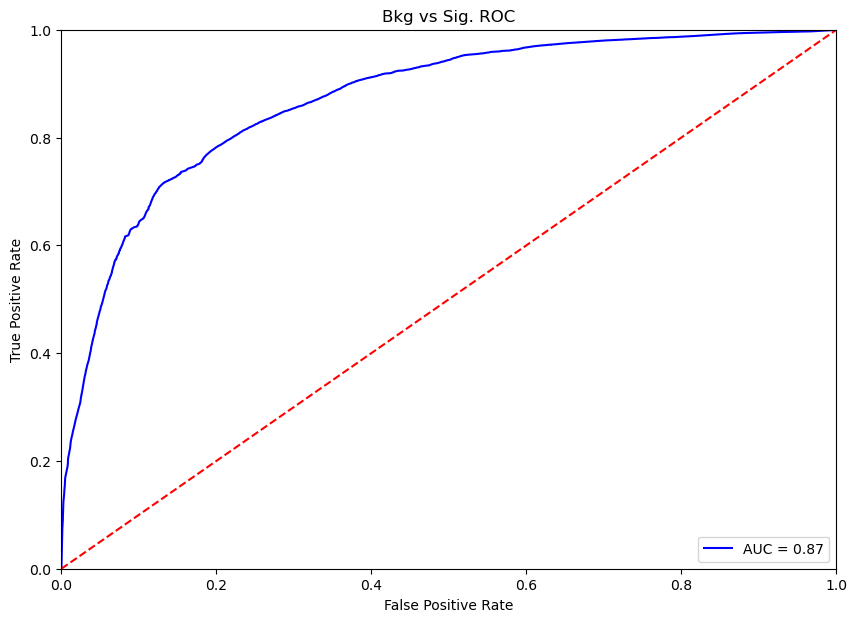

In [48]:
probs = bdt_bin.predict_proba(x_test_control)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test_control_bin, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.figure(figsize=(10,7))
plt.title('Bkg vs Sig. ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [49]:
classes = [1, 2, 3, 4]
fpr_tpr_auc = {}
for i in classes:
    new = classes.copy()
    new.remove(i)
    print(new)
    y_test_new = y_test_control.replace(to_replace=new, value=0)
    y_test_new = y_test_new.replace(i, 1)
    probs = bdt.predict_proba(x_test_control)
    preds = probs[:, 1]
    fp, tp, thresh = roc_curve(y_test_new, preds)
    roc_auc = auc(fp, tp)
    fpr_tpr_auc[i] = {}
    fpr_tpr_auc[i]['fpr'] = fp
    fpr_tpr_auc[i]['tpr'] = tp
    fpr_tpr_auc[i]['roc_auc'] = roc_auc
    fpr_tpr_auc[i]['threshold'] = thresh

[2, 3, 4]
[1, 3, 4]
[1, 2, 4]
[1, 2, 3]


Model A optimum classification threshold: 0.484
Model B optimum classification threshold: 0.481
Model C optimum classification threshold: 0.480
Model D optimum classification threshold: 0.486


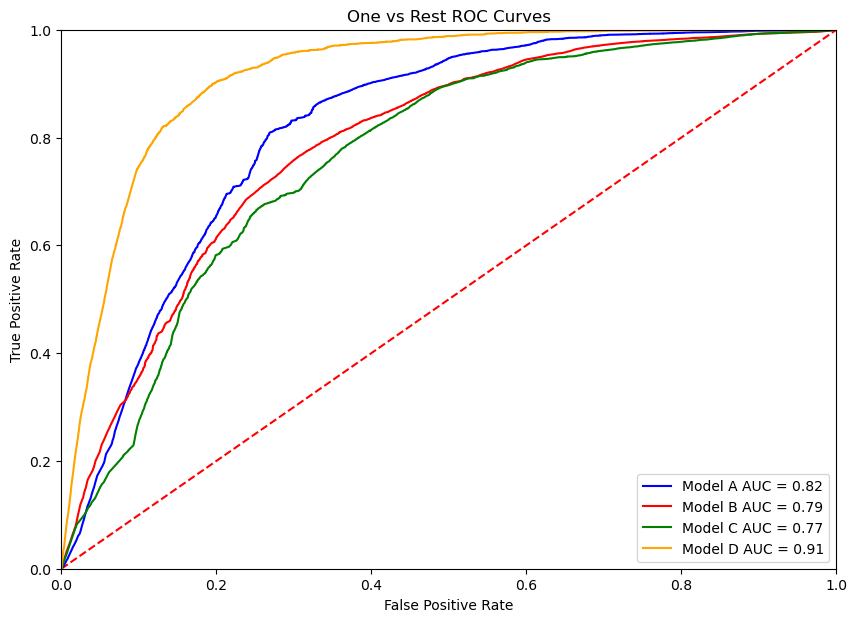

In [50]:
models = ['Bkg', 'A', 'B', 'C', 'D']
colours = ['None', 'b', 'r', 'g', 'orange']
plt.figure(figsize=(10,7))
plt.title('One vs Rest ROC Curves')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
for i in fpr_tpr_auc.keys():
    plt.plot(fpr_tpr_auc[i]['fpr'], fpr_tpr_auc[i]['tpr'], 
             colours[i], label = 'Model %s AUC = %0.2f' %(models[i], fpr_tpr_auc[i]['roc_auc']))
    opt_thresh = fpr_tpr_auc[i]['threshold'][np.argmax(fpr_tpr_auc[i]['tpr']-fpr_tpr_auc[i]['fpr'])]
    print('Model %s optimum classification threshold: %0.3f'%(models[i], opt_thresh))
plt.legend(loc = 'lower right')
plt.show()

# train on pre, test on control

In [2]:
bdt = pkl.load(open('bdt_optimized_red.pkl', 'rb'))
bdt_bin = pkl.load(open('bdt_bin_optimized_red.pkl', 'rb'))

# Multi-class

In [11]:
y_preds = bdt.predict(x_test_control)
precision = precision_score(y_test_control, y_preds, average='weighted')
recall = recall_score(y_test_control, y_preds, average = 'weighted')
f1 = f1_score(y_test_control, y_preds, average = 'weighted')
accuracy = accuracy_score(y_test_control, y_preds)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

Precision: 0.745
Recall: 0.589
F1: 0.648
Accuracy: 0.589


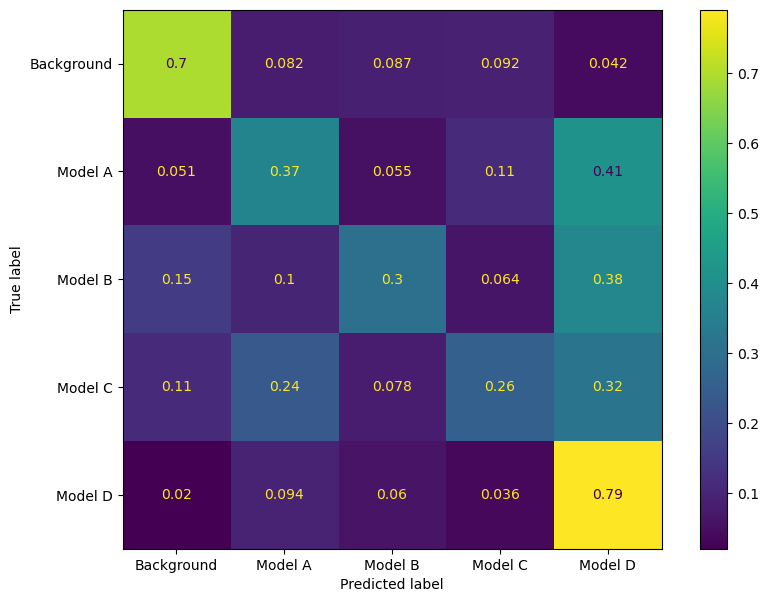

In [12]:
cm = confusion_matrix(y_test_control.values, y_preds, normalize='true')
tick_labs = ['Background', 'Model A', 'Model B', 'Model C', 'Model D']
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
fig, ax = plt.subplots(figsize = (10, 7))
cm_display.plot(ax=ax)
plt.show()

# Binary

In [13]:
y_preds = bdt_bin.predict(x_test_control)
precision = precision_score(y_test_control_bin, y_preds)
recall = recall_score(y_test_control_bin, y_preds)
f1 = f1_score(y_test_control_bin, y_preds)
accuracy = accuracy_score(y_test_control_bin, y_preds)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

Precision: 0.448
Recall: 0.933
F1: 0.605
Accuracy: 0.650


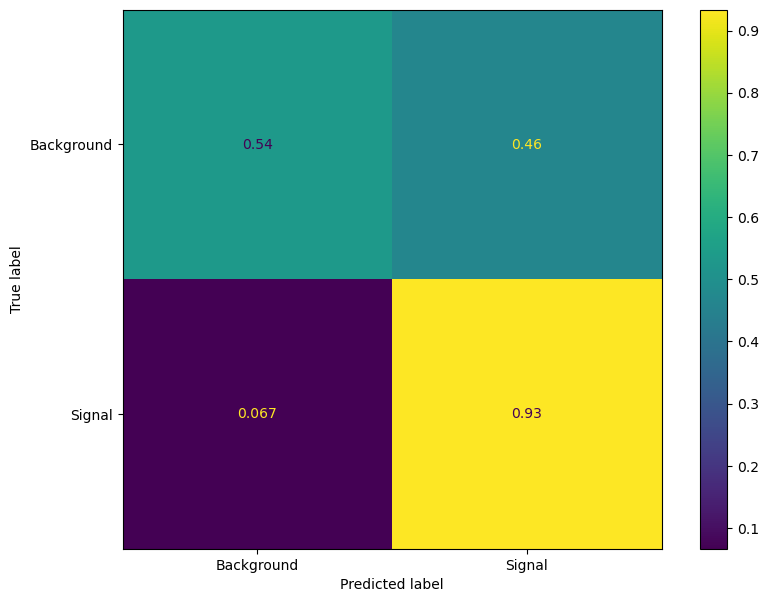

In [14]:
cm = confusion_matrix(y_test_control_bin.values, y_preds, normalize='true')
tick_labs = ['Background', 'Signal']
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
fig, ax = plt.subplots(figsize = (10, 7))
cm_display.plot(ax=ax)
plt.show()

# Scores

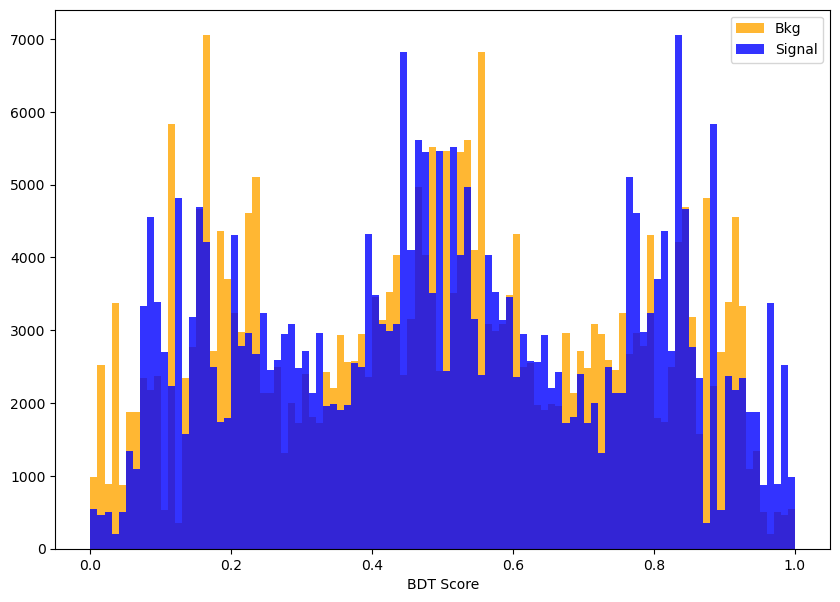

In [11]:
probs = bdt_bin.predict_proba(x_test_control)
preds = probs[:, 1]

scaled = MinMaxScaler().fit_transform(probs)
plt.figure(figsize=(10,7))
plt.hist(x=scaled[:,0], color='orange', label = 'Bkg', bins=100, alpha=0.8)
plt.hist(x=scaled[:,1], color='blue', label = 'Signal', bins=100, alpha=0.8)
plt.xlabel('BDT Score')
plt.legend()
plt.savefig('plots/fixed_scores/bdt_bin_scores_control_test.png')
plt.show()

classes = [1, 2, 3, 4]
models = ['bkg','A', 'B', 'C', 'D']
for i in classes:
    new = classes.copy()
    new.remove(i)
    print(new)
    #y_test_new = y_test.replace(to_replace=new, value=0)
    #y_test_new = y_test_new.replace(i, 1)
    y_train_new = y_train.replace(to_replace = new, value = 0)
    y_train_new = y_train_new.replace(i, 1)
    bdt.fit(x_train, y_train_new)
    probs = bdt.predict_proba(x_test_control)
    preds = probs[:, 1]
    print(preds)
    scaled = MinMaxScaler().fit_transform(probs)
    plt.figure(figsize=(10,7))
    sns.histplot(x=scaled[:,0], color='orange', label = 'Model %s'%models[i], bins=100)
    sns.histplot(x=scaled[:,1], color='cyan', label = 'Bkg and Others', bins=100)
    plt.xlabel('BDT Score')
    plt.legend()
    plt.show()

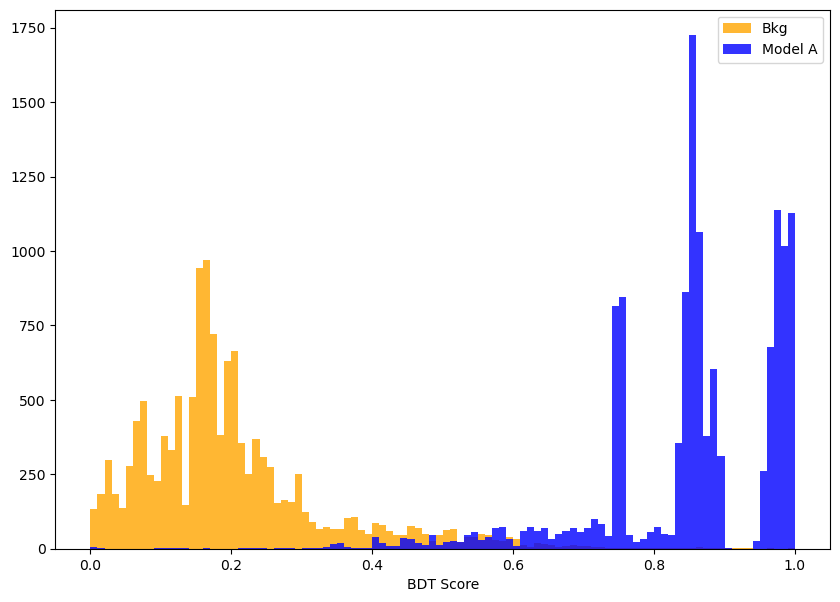

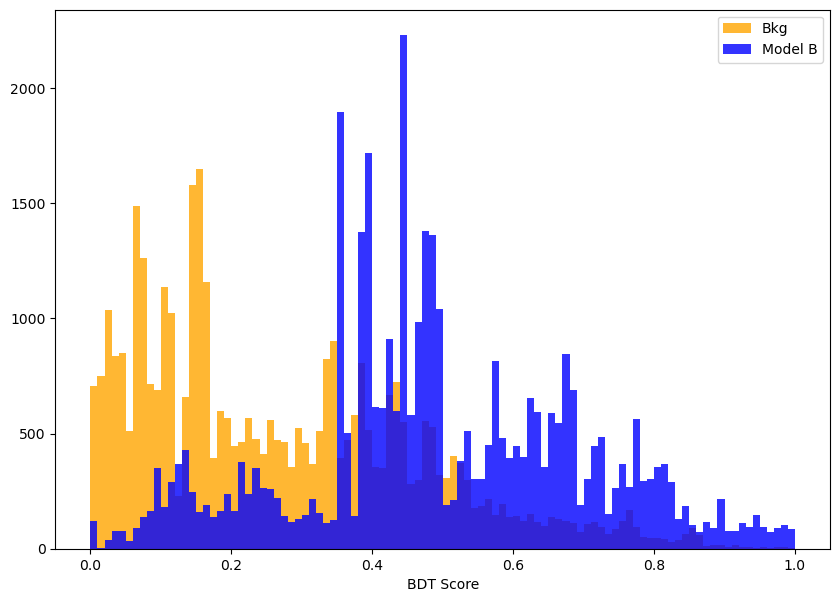

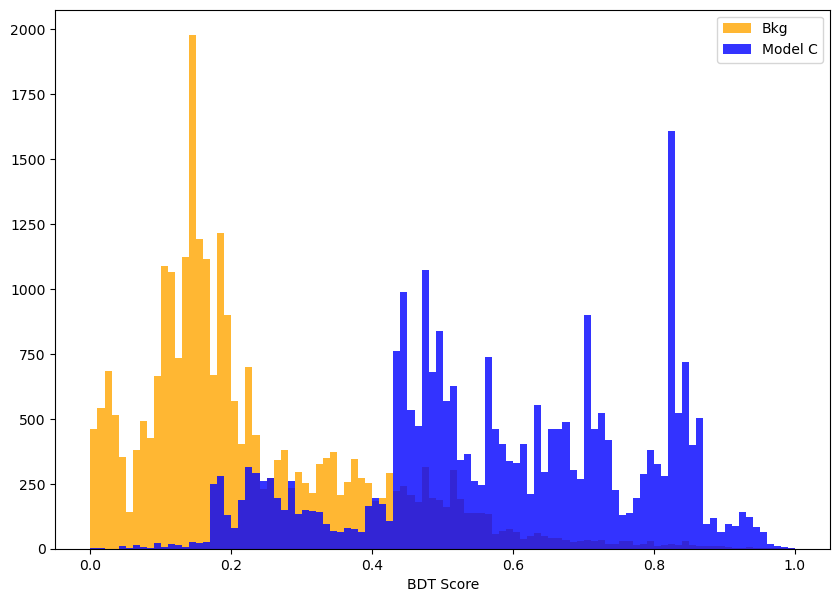

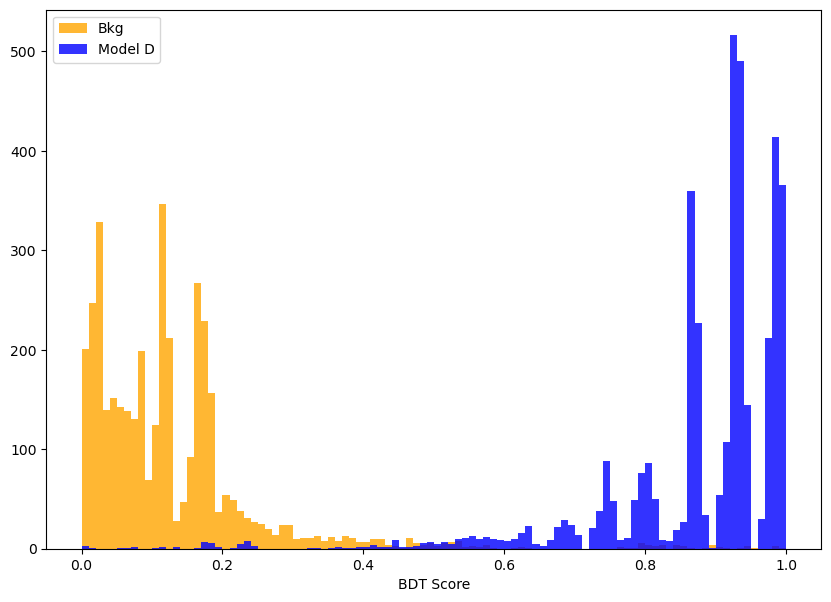

In [13]:
classes = [1, 2, 3, 4]
models = ['bkg','A', 'B', 'C', 'D']
for i in classes:
    test = np.array([x_test_control[j] for j in range(len(y_test_control)) if (y_test_control.values[j] == i)])
    probs = bdt.predict_proba(test)
    
    scaled = MinMaxScaler().fit_transform(probs)
    plt.figure(figsize=(10,7))
    plt.hist(x=scaled[:,0], color='orange', label = 'Bkg', bins=100, alpha=0.8)
    plt.hist(x=scaled[:,i], color='blue', label = 'Model %s'%models[i], bins=100, alpha=0.8)
    plt.xlabel('BDT Score')
    plt.legend()
    plt.savefig('plots/fixed_scores/bdt_bkg_vs_model%s_scores_control_test.png'%models[i])
    plt.show()

# ROC Curves

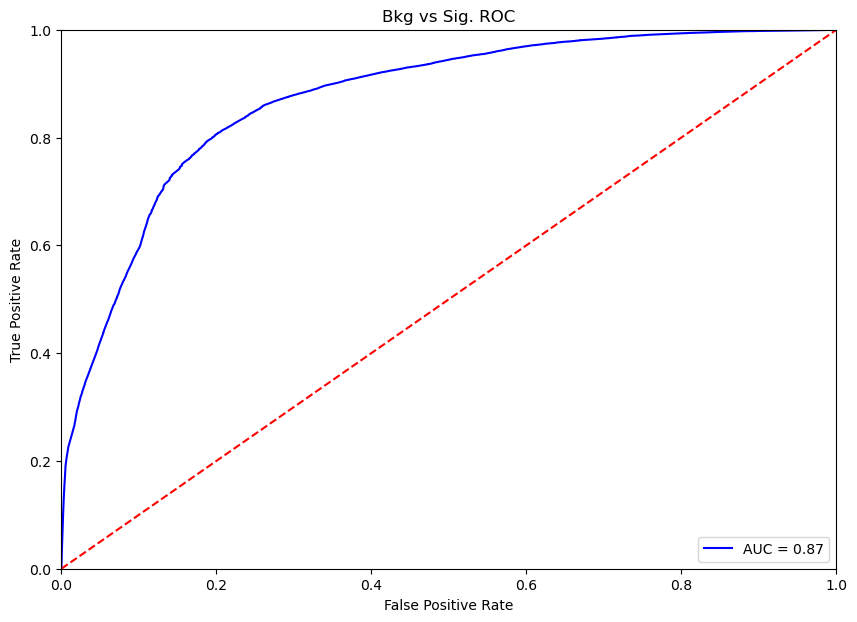

In [14]:
probs = bdt_bin.predict_proba(x_test_control)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test_control_bin, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.figure(figsize=(10,7))
plt.title('Bkg vs Sig. ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('plots/fixed_rocs/bdt_bin_roc_control_test.png')
plt.show()

classes = [1, 2, 3, 4]
fpr_tpr_auc = {}
for i in classes:
    new = classes.copy()
    new.remove(i)
    print(new)
    y_test_new = y_test_control.replace(to_replace=new, value=0)
    y_test_new = y_test_new.replace(i, 1)
    probs = bdt.predict_proba(x_test_control)
    preds = probs[:, 1]
    fp, tp, thresh = roc_curve(y_test_new, preds)
    roc_auc = auc(fp, tp)
    fpr_tpr_auc[i] = {}
    fpr_tpr_auc[i]['fpr'] = fp
    fpr_tpr_auc[i]['tpr'] = tp
    fpr_tpr_auc[i]['roc_auc'] = roc_auc
    fpr_tpr_auc[i]['threshold'] = thresh

In [12]:
classes = [1, 2, 3, 4]
fpr_tpr_auc = {}
for i in classes:
    x_test_new = [x_test_control[j] for j in range(len(y_test_control)) if (y_test_control.values[j] == i) or (y_test_control.values[j] == 0)]
    y_test_new = [k for k in y_test_control.values if (k==i) or (k==0)]
    probs = bdt.predict_proba(x_test_new)
    preds = probs[:, i]
    fp, tp, thresh = roc_curve(y_test_new, preds, pos_label=i)
    roc_auc = auc(fp, tp)
    fpr_tpr_auc[i] = {}
    fpr_tpr_auc[i]['fpr'] = fp
    fpr_tpr_auc[i]['tpr'] = tp
    fpr_tpr_auc[i]['roc_auc'] = roc_auc
    fpr_tpr_auc[i]['threshold'] = thresh

Model A optimum classification threshold: 0.201
Model B optimum classification threshold: 0.200
Model C optimum classification threshold: 0.201
Model D optimum classification threshold: 0.199


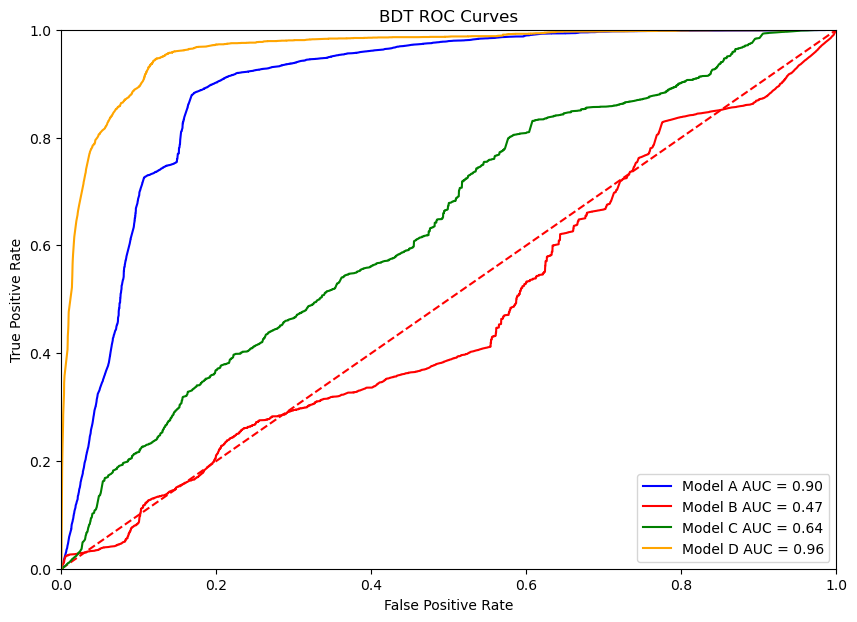

In [13]:
models = ['Bkg', 'A', 'B', 'C', 'D']
colours = ['None', 'b', 'r', 'g', 'orange']
plt.figure(figsize=(10,7))
plt.title('BDT ROC Curves')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
for i in fpr_tpr_auc.keys():
    plt.plot(fpr_tpr_auc[i]['fpr'], fpr_tpr_auc[i]['tpr'], 
             colours[i], label = 'Model %s AUC = %0.2f' %(models[i], fpr_tpr_auc[i]['roc_auc']))
    opt_thresh = fpr_tpr_auc[i]['threshold'][np.argmax(fpr_tpr_auc[i]['tpr']-fpr_tpr_auc[i]['fpr'])]
    print('Model %s optimum classification threshold: %0.3f'%(models[i], opt_thresh))
plt.legend(loc = 'lower right')
plt.savefig('plots/fixed_rocs/bdt_roc_control_test.png')
plt.show()